# **Time Series Prediction with LSTM Using PyTorch**

This kernel is based on *datasets* from

[Time Series Forecasting with the Long Short-Term Memory Network in Python](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)

[Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

## Reference
- https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb

## **Download Dataset**

In [1]:
#!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv

In [168]:
data_path = 'timeline_diagnosed.csv'
# !wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

## **Import Packages**

In [169]:
# For data preprocess
import os
import csv
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Pytorch
import torch
import torch.nn as nn
from torch.autograd import Variable

## **Set Random Seed**

In [242]:
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
same_seeds(12345)

## **Get GPU Resource**

In [243]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'
device = get_device()
print(device)

cuda


## **Data Plot**
Check raw data.

      city        date  count  accumulateCount
0      KEE  2020-01-28      0                0
1      NWT  2020-01-28      0                0
2      TPE  2020-01-28      0                0
3      TAO  2020-01-28      0                0
4      HSZ  2020-01-28      0                0
...    ...         ...    ...              ...
19683  TTT  2022-06-01    879            15445
19684  PEN  2022-06-01    216             3277
19685  KIN  2022-06-01    145             2582
19686  LIE  2022-06-01     25              665
19687   TW  2022-06-01  76943          2184454

[19688 rows x 4 columns]


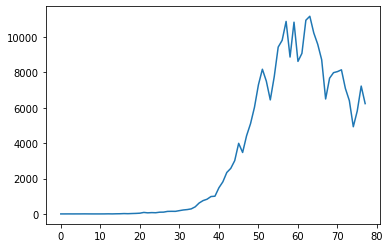

In [244]:
start_date = "2022-03-16"

training_set = pd.read_csv(data_path)
print(training_set)

mask = ((training_set["city"] == "TPE") & (training_set["date"] >= start_date))
training_set = training_set[mask]["count"].values.reshape(-1, 1)
# print(training_set)

plt.plot(training_set, label = 'COVID-19 New Cases')
plt.show()

## **Preprocessing**

In [245]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 3
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
dev_size = int(len(y) * 0.1)
test_size = len(y) - train_size - dev_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

devX = Variable(torch.Tensor(np.array(x[train_size:train_size+dev_size])))
devY = Variable(torch.Tensor(np.array(y[train_size:train_size+dev_size])))

testX = Variable(torch.Tensor(np.array(x[train_size+dev_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size+dev_size:len(y)])))

## **Model**
LSTM + fully connected layer

In [246]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, 
            x.size(0), 
            self.hidden_size,
            device=device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers,
            x.size(0),
            self.hidden_size,
            device=device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

## **Setup Hyper-parameters**

In [247]:
num_epochs = 10000
early_stop = 2000   # < num_epochs
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1
num_classes = 1
os.makedirs('models', exist_ok=True)
save_path = "models/model.pth"

criterion = torch.nn.MSELoss()    # mean-squared error for regression

#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# **Train/Test**

## **Training**

In [248]:
def train(model):
    min_loss = np.infty
    loss_record = {'train': [], 'dev': []}
    early_stop_cnt = 0
    _trainX, _trainY = trainX.to(device), trainY.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        pred = model(_trainX)
        
        # obtain the loss function
        loss = criterion(pred, _trainY)
        loss.backward()
        optimizer.step()
        loss_record['train'].append(loss.detach().cpu().item())

        dev_loss = dev(model)
        if dev_loss < min_loss:
            min_loss = dev_loss
            print('Saving model (epoch = {:4d}, val loss = {:.4f})'
                .format(epoch + 1, min_loss))
            torch.save(model.state_dict(), save_path)
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        loss_record['dev'].append(dev_loss)

        if (epoch+1) % 100 == 0:
            print("Epoch: %d, loss: %1.5f, %1.5f" % (epoch+1, loss.item(), dev_loss))
        if early_stop_cnt > early_stop:
            break
    
    return min_loss, loss_record

## **Validation**

In [249]:
def dev(model):
    model.eval()
    _devX, _devY = devX.to(device), devY.to(device)
    with torch.no_grad():
        pred = model(_devX)
        loss = criterion(pred, _devY)
    total_loss = loss.detach().cpu().item()

    return total_loss

In [250]:
lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)
min_loss, loss_record = train(lstm)

Saving model (epoch =    1, val loss = 0.3179)
Saving model (epoch =   12, val loss = 0.3092)
Saving model (epoch =   13, val loss = 0.2973)
Saving model (epoch =   14, val loss = 0.2840)
Saving model (epoch =   15, val loss = 0.2698)
Saving model (epoch =   16, val loss = 0.2550)
Saving model (epoch =   17, val loss = 0.2398)
Saving model (epoch =   18, val loss = 0.2245)
Saving model (epoch =   19, val loss = 0.2094)
Saving model (epoch =   20, val loss = 0.1944)
Saving model (epoch =   21, val loss = 0.1798)
Saving model (epoch =   22, val loss = 0.1656)
Saving model (epoch =   23, val loss = 0.1518)
Saving model (epoch =   24, val loss = 0.1382)
Saving model (epoch =   25, val loss = 0.1249)
Saving model (epoch =   26, val loss = 0.1118)
Saving model (epoch =   27, val loss = 0.0987)
Saving model (epoch =   28, val loss = 0.0857)
Saving model (epoch =   29, val loss = 0.0728)
Saving model (epoch =   30, val loss = 0.0603)
Saving model (epoch =   31, val loss = 0.0488)
Saving model 

## **Training and Validation Loss**

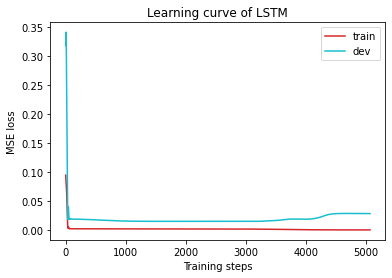

In [251]:
total_steps = len(loss_record['train'])
x_1 = range(total_steps)
x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
figure(figsize=(6, 4))
plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
plt.xlabel('Training steps')
plt.ylabel('MSE loss')
plt.title('Learning curve of LSTM')
plt.legend()
plt.show()

## **Testing**

In [252]:
def test(model, X, Y):
    model.eval()
    _X, _Y = X.to(device), Y.to(device)
    test_predict = model(_X)
    loss = criterion(test_predict, _Y)
    print("loss: %1.5f" % (loss.item()))

    return test_predict.detach().cpu()



In [253]:
del lstm
lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)
ckpt = torch.load(save_path, map_location='cpu')
lstm.load_state_dict(ckpt)
test_predict = test(lstm, testX, testY)

loss: 0.01149


# **Plot the Result**

## **Only Test Data**

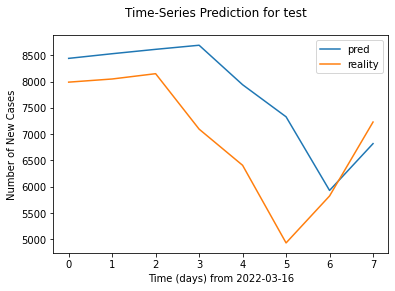

In [254]:
test_predict = test_predict.data.numpy()
testY_plot = testY.data.numpy()

test_predict = sc.inverse_transform(test_predict)
testY_plot = sc.inverse_transform(testY_plot)

plt.plot(test_predict)
plt.plot(testY_plot)
plt.suptitle('Time-Series Prediction for test')
plt.xlabel(f"Time (days) from {start_date}")
plt.ylabel("Number of New Cases")
plt.legend(("pred", "reality"))
plt.show()

## **All Data**

loss: 0.00413


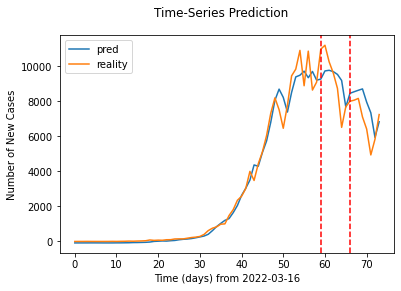

In [255]:
data_predict = test(lstm, dataX, dataY)

data_predict = data_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.plot(data_predict)
plt.plot(dataY_plot)
plt.suptitle('Time-Series Prediction')
plt.xlabel(f"Time (days) from {start_date}")
plt.ylabel("Number of New Cases")
plt.legend(("pred", "reality"))

plt.axvline(x=(train_size), c='red', linestyle='--')
plt.axvline(x=(train_size + dev_size), c='r', linestyle='--')

plt.show()